# Pitch Classifier

## Load the Data

In [7]:
import pandas as pd

In [8]:
pitches = pd.read_csv('data/2019-06-17_547888_Tanaka.csv')

In [9]:
pitches.head()

,start_speed,pfx_x,pfx_z,mlbam_pitch_name
0,91.87,-4.517746,9.332202,FF
1,83.05,1.624604,1.942790,SL
2,91.21,-7.260078,7.255023,FF
3,81.80,4.409871,0.787128,SL
4,80.63,5.149924,2.596144,SL


In [10]:
pitches.columns

Index(['start_speed', 'pfx_x', 'pfx_z', 'mlbam_pitch_name'], dtype='object')

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
pitches['mlbam_pitch_name'].unique()

array(['FF', 'SL', 'FS', 'CH', 'CU', 'SI', 'FT'], dtype=object)

In [39]:
COLORS = {
    'FF': 'red',
    'SL': 'green',
    'FS': 'blue',
    'CH': 'orange',
    'CU': 'grey',
    'SI': 'purple',
    'FT': 'brown',
}

In [42]:
PITCH_TYPES = {
    'FA': 'fastball',
    'FF': 'four-seam fastball',
    'FT': 'two-seam fastball',
    'FC': 'cutter',
    'FS': 'fastball',
    'SI': 'sinker',
    'FS': 'split-fingered fastball',
    'SL': 'slider',
    'CH': 'changeup',
    'CB': 'curveball',
    'CU': 'curveball',
    'KC': 'knuckle-curve',
    'KN': 'knuckleball',
    'EP': 'eephus',
    'UN': 'unidentified',
    'XX': 'unidentified',
    'PO': 'pitch out',
    'FO': 'pitch out',
}

In [40]:
colors = [ COLORS.get(pitch_type, 'black') for pitch_type in pitches['mlbam_pitch_name']]

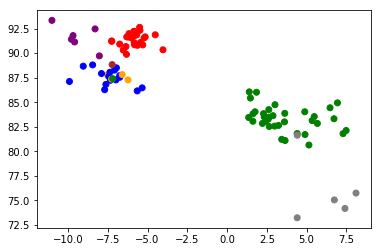

In [41]:
plt.scatter(pitches['pfx_x'], pitches['start_speed'], c=colors)

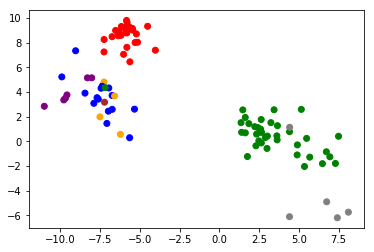

In [43]:
plt.scatter(pitches['pfx_x'], pitches['pfx_z'], c=colors)

## Normalize the Data

In [6]:
cols_to_norm = ['start_speed', 'pfx_x', 'pfx_z']

In [8]:
pitches[cols_to_norm] = pitches[cols_to_norm].apply(lambda x: (x-x.min()) / (x.max() - x.min()))

In [9]:
pitches.head()

,start_speed,pfx_x,pfx_z,mlbam_pitch_name
0,0.926975,0.339739,0.970198,FF
1,0.488823,0.660851,0.508245,SL
2,0.894188,0.196375,0.840342,FF
3,0.426726,0.806460,0.435998,SL
4,0.368604,0.845149,0.549089,SL


In [1]:
import tensorflow as tf

In [4]:
start_speed = tf.feature_column.numeric_column('start_speed')
pfx_x = tf.feature_column.numeric_column('pfx_x')
pfx_z = tf.feature_column.numeric_column('pfx_z')

In [25]:
feat_cols = [start_speed, pfx_x, pfx_z]

## Train Test Split

In [28]:
pitches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 4 columns):
start_speed         95 non-null float64
pfx_x               95 non-null float64
pfx_z               95 non-null float64
mlbam_pitch_name    95 non-null object
dtypes: float64(3), object(1)
memory usage: 3.0+ KB


In [29]:
x_data = pitches.drop('mlbam_pitch_name', axis=1)

In [30]:
labels = pitches['mlbam_pitch_name']

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(x_data, labels, test_size=0.33, random_state=101)

## Input Function

In [33]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train, y=y_train, batch_size=10, num_epochs=1000, shuffle=True)

In [34]:
model = tf.estimator.LinearClassifier(feature_columns=feat_cols, n_classes=6)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/kb/s3s7jjy90yx_6r9ztgl83y_m0000gp/T/tmpkuaglnp0', '_log_step_count_steps': 100, '_tf_random_seed': 1, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_session_config': None, '_keep_checkpoint_every_n_hours': 10000}


In [44]:
#model.train(input_fn=input_func, steps=1000)